## Imports

In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, utils
import torchvision.transforms as transforms


## Functions

In [154]:
def imshow(img):
    '''
    display tensor images
    '''
    img = utils.make_grid(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [25]:
def total_variation_loss(x):
    '''
    computes the total variation loss
    '''
    du = torch.sum(torch.pow((x[:,:,:,1:] - x[:,:,:,:-1]), 2))
    dv = torch.sum(torch.pow((x[:,:,1:,:] - x[:,:,:-1,:]), 2))
    loss = du + dv
    return loss

In [161]:
def feature_inversion(model, img, device, lr, epochs, step_size = 100, alpha = 6, gamma = 0.5, tv_weight = 50):
    '''
    implemetation of the feature inversion method
    '''
    # use GPU if possible
    model.to(device)
    img = img.to(device)
    
    # set for inference
    model.eval()
    
    # create hooks for the FC layers
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output
        return hook
    
    handle = model.features[4].register_forward_hook(get_activation('fc'))
    
    # get feature output for input image
    _ = model(img)
    fc_features = activation['fc'][0]
    
    # lets make some noise
    # for the input
    noise = 0.1 * torch.randn([1,3,227,227])
    noise = noise.to(device)
    noise.requires_grad = True
    
    # we optimize the input using SGD
    optimizer = optim.SGD([noise], lr = lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)
    for i in range(epochs):
        optimizer.zero_grad()
        _ = model(noise)
        curr_fc_features = activation['fc'][0]
        
        # compute the loss function
        mse_loss = 0.1 * torch.norm(fc_features - curr_fc_features)/torch.norm(fc_features)
        tv_loss = tv_weight * total_variation_loss(noise)
        
        loss = mse_loss + tv_loss
        if i%10 == 0:
            print(loss.item())
        
        loss.backward(retain_graph = True)
        
        optimizer.step()
        scheduler.step()
    
    handle.remove()
    return noise
        

In [166]:
def recreate_image(img):
    '''
    normalise the image again to be able to display
    '''
    normalise = transforms.Normalize(\
                            mean=[-0.406, -0.456, -0.485],
                            std=[1/0.225, 1/0.224, 1/0.229])

    img = normalise(img)

    # make sure the image in within [0, 1]
    img = torch.clip(img, min = 0.0, max = 1.0)

    return img

## Inverting CNN Features

In [137]:
# load pretrained alexnet model
model = models.alexnet(pretrained=True)

In [165]:
# gpu is possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [180]:
# load image for testing
img = cv2.imread('assets/tractor.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [181]:
# some transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean=[0.406, 0.456, 0.485],
                                 std=[0.225, 0.224, 0.229]),
    transforms.CenterCrop(size=(227,227))]
)

In [182]:
# convert image to torch tensor
torch_img = transform(img)
torch_img = torch_img.unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


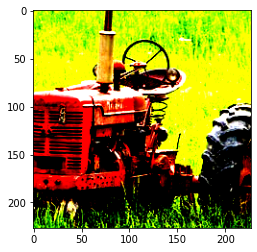

In [183]:
imshow(torch_img)

In [169]:
# get the reconstruction
res = feature_inversion(model, torch_img, device = device, lr = 1e4, step_size = 40, gamma = 0.1, epochs = 200, tv_weight=1e-8)

0.09780916571617126
0.045165352523326874
0.030742211267352104
0.024463914334774017
0.02178768627345562
0.020004339516162872
0.01921287551522255
0.01863574981689453
0.01812136545777321
0.01805262081325054
0.017989451065659523
0.01793578825891018
0.01788768544793129
0.01788286119699478
0.017878158017992973
0.01787360943853855
0.017869172617793083
0.01786871813237667
0.017868274822831154
0.017867837101221085


In [171]:
res = recreate_image(res)

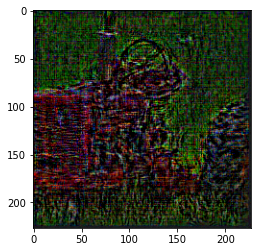

In [172]:
# display reconstructed image
imshow(res.cpu().detach())